<a href="https://colab.research.google.com/github/Legajo/Colab-Notebooks/blob/main/HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## ============================================================================
## QUESTION 2: COMPLETE STANDALONE CODE
## Includes data loading, preprocessing, model training, and new hand rules
## ============================================================================

# ============================================================================
# STAGE 0: SETUP AND DATA LOADING
# ============================================================================

print("=" * 80)
print("STAGE 0: SETUP AND DATA LOADING")
print("=" * 80)

# Import libraries
print("\n✓ Importing libraries...")
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score

print("✓ Libraries imported successfully")

# Mount Google Drive
print("\n✓ Mounting Google Drive...")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✓ Google Drive mounted")
except:
    print("⚠️  Not in Colab environment or Drive already mounted")

# Install required packages
print("\n✓ Installing packages...")
!pip install gdown -q

# Check if file exists, if not download it
import os

# Try Google Drive first (permanent storage)
drive_path = "/content/drive/MyDrive/Colab Notebooks/stocks_df_combined_2025_06_13.parquet.brotli"
content_path = "/content/stocks_df_combined_2025_06_13.parquet.brotli"

if os.path.exists(drive_path):
    print(f"\n✓ File found in Google Drive")
    file_path = drive_path
elif os.path.exists(content_path):
    print(f"\n✓ File found in /content/")
    file_path = content_path
else:
    print(f"\n⚠️  File not found. Downloading to /content/...")
    !gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/
    file_path = content_path

    if os.path.exists(content_path):
        file_size = os.path.getsize(content_path) / (1024*1024)
        print(f"✓ File downloaded successfully! Size: {file_size:.2f} MB")
    else:
        raise FileNotFoundError("❌ Download failed! Please check your internet connection.")

# Load data
print(f"\nLoading data from: {file_path}")
df_full = pd.read_parquet(file_path)
print(f"✓ Loaded df_full: {df_full.shape}")

# Truncate to 25 years (2000+)
df = df_full[df_full.Date >= '2000-01-01'].copy()
print(f"✓ Truncated to df: {df.shape}")

# Define variable lists
GROWTH = [g for g in df.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']
TO_PREDICT = [g for g in df.keys() if (g.find('future')>=0)]
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV

# Create custom features
df['ln_volume'] = df.Volume.apply(lambda x: np.log(x) if x > 0 else 0)

CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

TECHNICAL_PATTERNS = [g for g in df.keys() if g.find('cdl')>=0]

MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

print(f"\n✓ Features defined: {len(NUMERICAL)} numerical")


STAGE 0: SETUP AND DATA LOADING

✓ Importing libraries...
✓ Libraries imported successfully

✓ Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Google Drive mounted

✓ Installing packages...

✓ File found in Google Drive

Loading data from: /content/drive/MyDrive/Colab Notebooks/stocks_df_combined_2025_06_13.parquet.brotli
✓ Loaded df_full: (230262, 203)
✓ Truncated to df: (191795, 203)

✓ Features defined: 184 numerical


In [ ]:
# ============================================================================
# STAGE 1: CREATE DUMMIES AND PREPARE DATA
# ============================================================================

print("\n" + "="*80)
print("STAGE 1: CREATE CATEGORICAL DUMMIES")
print("="*80)

# Create Month and Weekday
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.strftime('%B')
df['Weekday'] = df['Date'].dt.day_name().astype(str)

# Generate dummy variables
print("\n✓ Generating dummy variables...")
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')
DUMMIES = dummy_variables.keys().to_list()
print(f"  Total dummy variables: {len(DUMMIES)}")

# Concatenate dummies with original dataframe
new_df = pd.concat([df, dummy_variables], axis=1)
print(f"✓ Created new_df: {new_df.shape}")


STAGE 1: CREATE CATEGORICAL DUMMIES

✓ Generating dummy variables...
  Total dummy variables: 55
✓ Created new_df: (191795, 259)


In [ ]:
# ============================================================================
# STAGE 2: CREATE BASE MANUAL PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("STAGE 2: CREATE BASE MANUAL PREDICTIONS")
print("="*80)

new_df['pred0_manual_cci'] = (new_df.cci > 200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d > 1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)

print("✓ Created base predictions (pred0, pred1, pred2)")

# ============================================================================
# STAGE 3: TEMPORAL SPLIT
# ============================================================================

print("\n" + "="*80)
print("STAGE 3: TEMPORAL TRAIN/VALIDATION/TEST SPLIT")
print("="*80)

def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    df['split'] = split_labels
    return df

min_date_df = new_df.Date.min()
max_date_df = new_df.Date.max()

new_df = temporal_split(new_df, min_date=min_date_df, max_date=max_date_df)

split_counts = new_df['split'].value_counts()
print(f"\n✓ Split distribution:")
for split in ['train', 'validation', 'test']:
    count = split_counts[split]
    pct = count / len(new_df) * 100
    print(f"  {split}: {count} ({pct:.1f}%)")


STAGE 2: CREATE BASE MANUAL PREDICTIONS
✓ Created base predictions (pred0, pred1, pred2)

STAGE 3: TEMPORAL TRAIN/VALIDATION/TEST SPLIT

✓ Split distribution:
  train: 129730 (67.6%)
  validation: 30657 (16.0%)
  test: 31408 (16.4%)


In [ ]:

# ============================================================================
# STAGE 4: TRAIN DECISION TREE MODEL (clf_10)
# ============================================================================

print("\n" + "="*80)
print("STAGE 4: TRAIN DECISION TREE MODEL (clf_10)")
print("="*80)

# Prepare features_list
features_list = NUMERICAL + DUMMIES
to_predict = 'is_positive_growth_30d_future'

print(f"\n✓ Total features: {len(features_list)}")
print(f"  - Numerical: {len(NUMERICAL)}")
print(f"  - Dummies: {len(DUMMIES)}")

# Prepare train and test data
train_df = new_df[new_df.split.isin(['train', 'validation'])].copy(deep=True)
test_df = new_df[new_df.split.isin(['test'])].copy(deep=True)

X_train = train_df[features_list + [to_predict, 'Date', 'Ticker']]
X_test = test_df[features_list + [to_predict, 'Date', 'Ticker']]

# Clean data
pd.options.mode.chained_assignment = None
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

y_train = X_train[to_predict]
y_test = X_test[to_predict]

del X_train[to_predict]
del X_test[to_predict]

print(f"\n✓ X_train: {X_train.shape}")
print(f"✓ X_test: {X_test.shape}")

# Train clf_10
print("\n✓ Training Decision Tree with max_depth=10...")
clf_10 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf_10.fit(X_train.drop(['Date', 'Ticker'], axis=1), y_train)

y_pred_10 = clf_10.predict(X_test.drop(['Date', 'Ticker'], axis=1))

accuracy_10 = accuracy_score(y_test, y_pred_10)
precision_10 = precision_score(y_test, y_pred_10)

print(f"\n✓ clf_10 trained successfully!")
print(f"  Accuracy:  {accuracy_10:.4f}")
print(f"  Precision: {precision_10:.4f}")

# Define train_columns
train_columns = features_list

print(f"\n✓ train_columns defined: {len(train_columns)} features")

# ============================================================================
# QUESTION 2 STARTS HERE
# ============================================================================

print("\n" + "="*80)
print("="*80)
print("QUESTION 2: NEW HAND RULES - pred3 and pred4")
print("="*80)
print("="*80)


STAGE 4: TRAIN DECISION TREE MODEL (clf_10)

✓ Total features: 239
  - Numerical: 184
  - Dummies: 55

✓ X_train: (160387, 241)
✓ X_test: (31408, 241)

✓ Training Decision Tree with max_depth=10...

✓ clf_10 trained successfully!
  Accuracy:  0.5495
  Precision: 0.5839

✓ train_columns defined: 239 features

QUESTION 2: NEW HAND RULES - pred3 and pred4



PART 1: DECISION TREE VISUALIZATION (clf_10)


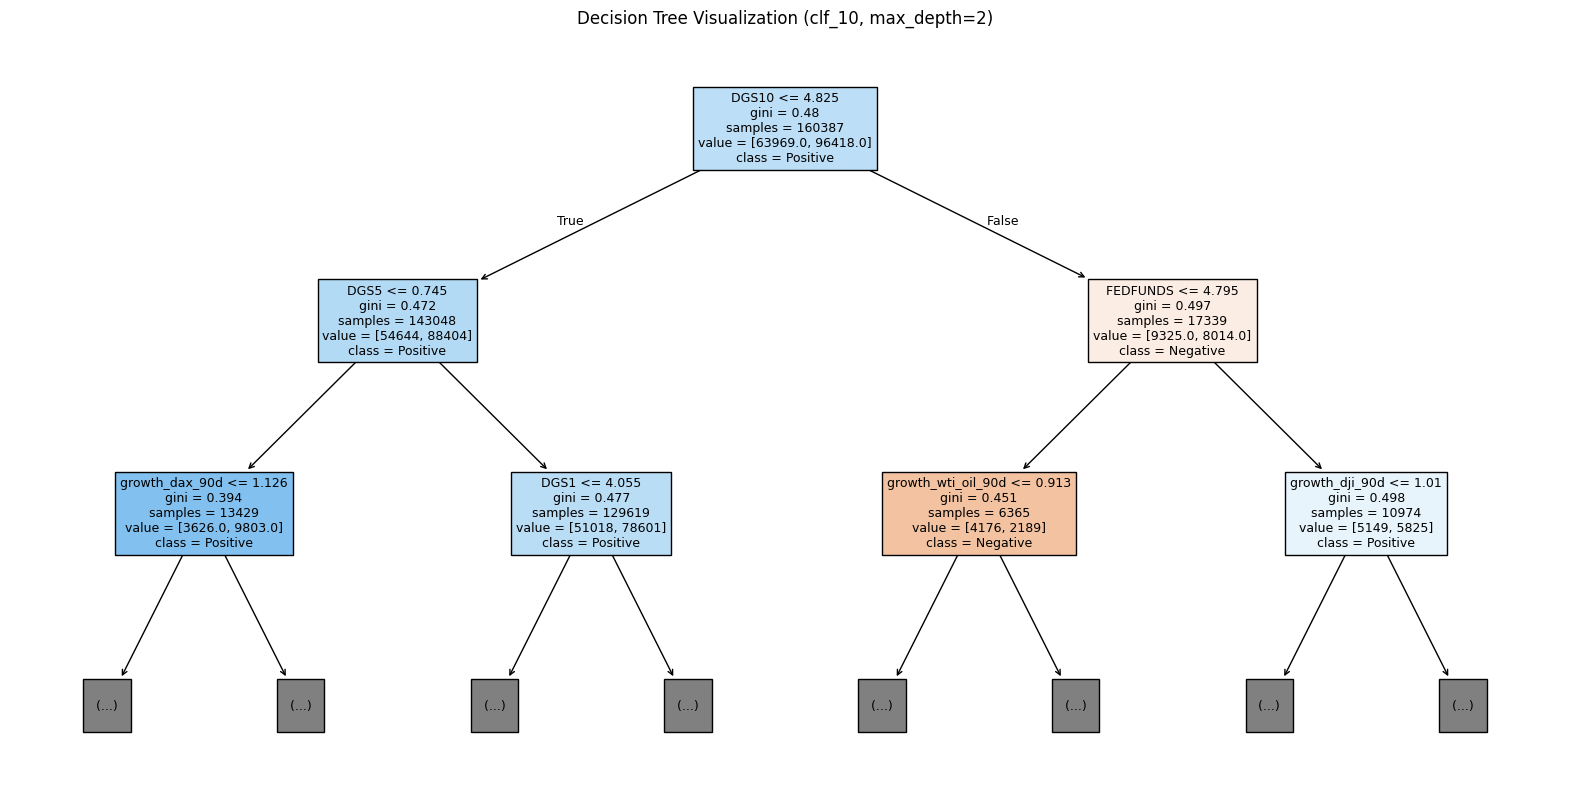


✓ Decision tree visualized!
  Examine the tree branches to understand the rules for pred3 and pred4.


In [ ]:
# ============================================================================
# PART 1: VISUALIZE DECISION TREE clf_10
# ============================================================================

print("\n" + "="*80)
print("PART 1: DECISION TREE VISUALIZATION (clf_10)")
print("="*80)

plt.figure(figsize=(20,10))
plot_tree(clf_10,
          filled=True,
          feature_names=train_columns,
          class_names=['Negative', 'Positive'],
          max_depth=2)
plt.title('Decision Tree Visualization (clf_10, max_depth=2)')
plt.show()

print("\n✓ Decision tree visualized!")
print("  Examine the tree branches to understand the rules for pred3 and pred4.")


In [ ]:
# ============================================================================
# PART 2: FEATURE IMPORTANCE
# ============================================================================

def get_importances(clf, train_columns):
    """Get feature importance from trained classifier"""
    feature_importance = clf.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': train_columns,
        'Importance': feature_importance
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    return feature_importance_df

print("\n" + "="*80)
print("TOP 10 IMPORTANT FEATURES (clf_10)")
print("="*80)
importance_df = get_importances(clf_10, train_columns)
print(importance_df.head(10))



TOP 10 IMPORTANT FEATURES (clf_10)
                   Feature  Importance
183                  DGS10    0.071228
181                   DGS1    0.054734
178           cpi_core_yoy    0.046436
35        growth_gold_365d    0.039487
93                      ad    0.033139
16       growth_snp500_90d    0.032207
95                     obv    0.030841
41     growth_wti_oil_365d    0.030736
47   growth_brent_oil_365d    0.027400
5              growth_365d    0.027369


In [ ]:

# ============================================================================
# PART 3: CREATE NEW PREDICTIONS pred3 and pred4
# ============================================================================

print("\n" + "="*80)
print("PART 3: CREATING NEW HAND RULES (pred3 and pred4)")
print("="*80)

print("\nRules based on decision tree branches:")
print("-"*80)
print("Rule 3 (pred3_manual_dgs10_5):")
print("  (DGS10 <= 4) & (DGS5 <= 1)")
print("  - Based on tree branch: (DGS10 <= 4.825) & (DGS5 <= 0.745)")
print("  - Modified thresholds to ensure positive predictions exist")

print("\nRule 4 (pred4_manual_dgs10_fedfunds):")
print("  (DGS10 > 4) & (FEDFUNDS <= 4.795)")
print("  - Based on tree branch: (DGS10 > 4.825) & (FEDFUNDS <= 4.795)")
print("  - Modified to ensure positive predictions exist")
print("-"*80)

# Create pred3 and pred4
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

print("\n✓ New prediction columns created!")
print(f"  pred3_manual_dgs10_5: {new_df['pred3_manual_dgs10_5'].sum()} positive predictions (all data)")
print(f"  pred4_manual_dgs10_fedfunds: {new_df['pred4_manual_dgs10_fedfunds'].sum()} positive predictions (all data)")

# Check on test set
test_filter = new_df.split == 'test'
print(f"\nOn TEST set ({test_filter.sum()} rows):")
print(f"  pred3: {new_df[test_filter]['pred3_manual_dgs10_5'].sum()} positive predictions")
print(f"  pred4: {new_df[test_filter]['pred4_manual_dgs10_fedfunds'].sum()} positive predictions")



PART 3: CREATING NEW HAND RULES (pred3 and pred4)

Rules based on decision tree branches:
--------------------------------------------------------------------------------
Rule 3 (pred3_manual_dgs10_5):
  (DGS10 <= 4) & (DGS5 <= 1)
  - Based on tree branch: (DGS10 <= 4.825) & (DGS5 <= 0.745)
  - Modified thresholds to ensure positive predictions exist

Rule 4 (pred4_manual_dgs10_fedfunds):
  (DGS10 > 4) & (FEDFUNDS <= 4.795)
  - Based on tree branch: (DGS10 > 4.825) & (FEDFUNDS <= 4.795)
  - Modified to ensure positive predictions exist
--------------------------------------------------------------------------------

✓ New prediction columns created!
  pred3_manual_dgs10_5: 26238 positive predictions (all data)
  pred4_manual_dgs10_fedfunds: 36271 positive predictions (all data)

On TEST set (31408 rows):
  pred3: 997 positive predictions
  pred4: 5660 positive predictions


In [ ]:

# ============================================================================
# PART 4: UPDATE PREDICTIONS AND IS_CORRECT LISTS
# ============================================================================

print("\n" + "="*80)
print("PART 4: UPDATE PREDICTIONS LIST")
print("="*80)

# Update PREDICTIONS list
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
print(f"\n✓ All prediction columns ({len(PREDICTIONS)}):")
for pred in PREDICTIONS:
    print(f"  - {pred}")

# Generate is_correct columns for all predictions
for pred in PREDICTIONS:
    part1 = pred.split('_')[0]
    if f'is_correct_{part1}' not in new_df.columns:
        new_df[f'is_correct_{part1}'] = (new_df[pred] == new_df.is_positive_growth_30d_future).astype(int)

# Update IS_CORRECT list
IS_CORRECT = [k for k in new_df.keys() if k.startswith('is_correct_')]
print(f"\n✓ All is_correct columns ({len(IS_CORRECT)})")



PART 4: UPDATE PREDICTIONS LIST

✓ All prediction columns (5):
  - pred0_manual_cci
  - pred1_manual_prev_g1
  - pred2_manual_prev_g1_and_snp
  - pred3_manual_dgs10_5
  - pred4_manual_dgs10_fedfunds

✓ All is_correct columns (5)


In [ ]:

# ============================================================================
# PART 5: DISPLAY SAMPLE DATA
# ============================================================================

print("\n" + "="*80)
print("PART 5: SAMPLE DATA - New Predictions")
print("="*80)

sample_cols = ['pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds',
               'is_correct_pred3', 'is_correct_pred4', 'is_positive_growth_30d_future',
               'DGS10', 'DGS5', 'FEDFUNDS', 'split']
available_cols = [col for col in sample_cols if col in new_df.columns]

print("\nSample of 10 rows:")
print(new_df[available_cols].sample(min(10, len(new_df))))

# ============================================================================
# PART 6: CALCULATE PRECISION FOR ALL PREDICTIONS ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("PART 6: PRECISION CALCULATION FOR ALL PREDICTIONS (TEST SET)")
print("="*80)

precision_results = {}

print(f"\n{'Prediction':<40} {'Precision':<12} {'Count (pred=1)'}")
print("-" * 65)

for i, column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split == 'test') & (new_df[prediction_column] == 1)

    num_positive_predictions = len(new_df[filter])

    if num_positive_predictions > 0:
        precision = new_df[filter][is_correct_column].sum() / len(new_df[filter])
        print(f"{prediction_column:<40} {precision:<12.4f} {num_positive_predictions}")
        precision_results[prediction_column] = precision
    else:
        print(f"{prediction_column:<40} {'N/A':<12} {num_positive_predictions}")
        precision_results[prediction_column] = None



PART 5: SAMPLE DATA - New Predictions

Sample of 10 rows:
      pred3_manual_dgs10_5  pred4_manual_dgs10_fedfunds  is_correct_pred3  \
5394                     0                            0                 0   
3005                     0                            0                 1   
4172                     0                            0                 0   
5624                     0                            1                 0   
1187                     0                            1                 1   
3874                     0                            0                 1   
2656                     0                            1                 0   
3733                     0                            0                 1   
1822                     0                            0                 1   
678                      0                            1                 0   

      is_correct_pred4  is_positive_growth_30d_future  DGS10  DGS5  FEDFUNDS  \
5394         

In [ ]:

# ============================================================================
# PART 7: DETAILED ANALYSIS OF PRED3 AND PRED4
# ============================================================================

print("\n" + "="*80)
print("PART 7: DETAILED ANALYSIS - pred3 and pred4")
print("="*80)

# Find pred3 and pred4
pred3_idx = None
pred4_idx = None
for i, pred in enumerate(PREDICTIONS):
    if 'pred3' in pred and 'manual_dgs10_5' in pred:
        pred3_idx = i
    if 'pred4' in pred and 'manual_dgs10_fedfunds' in pred:
        pred4_idx = i

# Analyze pred3
if pred3_idx is not None:
    prediction_column = PREDICTIONS[pred3_idx]
    is_correct_column = IS_CORRECT[pred3_idx]
    filter_pred3 = (new_df.split == 'test') & (new_df[prediction_column] == 1)

    print(f"\n📊 {prediction_column}:")
    print(f"   Rule: (DGS10 <= 4) & (DGS5 <= 1)")
    print(f"   Positive predictions on TEST: {filter_pred3.sum()}")

    if filter_pred3.sum() > 0:
        value_counts = new_df[filter_pred3][is_correct_column].value_counts()
        print(f"   Correct: {value_counts.get(1, 0)}, Incorrect: {value_counts.get(0, 0)}")

        precision_pred3 = new_df[filter_pred3][is_correct_column].sum() / len(new_df[filter_pred3])
        print(f"   Precision: {precision_pred3:.6f} = {round(precision_pred3, 3)}")
    else:
        print("   No positive predictions on TEST set")
        precision_pred3 = None
else:
    precision_pred3 = None

print("\n" + "-"*80)

# Analyze pred4
if pred4_idx is not None:
    prediction_column = PREDICTIONS[pred4_idx]
    is_correct_column = IS_CORRECT[pred4_idx]
    filter_pred4 = (new_df.split == 'test') & (new_df[prediction_column] == 1)

    print(f"\n📊 {prediction_column}:")
    print(f"   Rule: (DGS10 > 4) & (FEDFUNDS <= 4.795)")
    print(f"   Positive predictions on TEST: {filter_pred4.sum()}")

    if filter_pred4.sum() > 0:
        value_counts = new_df[filter_pred4][is_correct_column].value_counts()
        print(f"   Correct: {value_counts.get(1, 0)}, Incorrect: {value_counts.get(0, 0)}")

        precision_pred4 = new_df[filter_pred4][is_correct_column].sum() / len(new_df[filter_pred4])
        print(f"   Precision: {precision_pred4:.6f} = {round(precision_pred4, 3)}")
    else:
        print("   No positive predictions on TEST set")
        precision_pred4 = None
else:
    precision_pred4 = None



PART 7: DETAILED ANALYSIS - pred3 and pred4

📊 pred3_manual_dgs10_5:
   Rule: (DGS10 <= 4) & (DGS5 <= 1)
   Positive predictions on TEST: 997
   Correct: 578, Incorrect: 419
   Precision: 0.579739 = 0.58

--------------------------------------------------------------------------------

📊 pred4_manual_dgs10_fedfunds:
   Rule: (DGS10 > 4) & (FEDFUNDS <= 4.795)
   Positive predictions on TEST: 5660
   Correct: 2640, Incorrect: 3020
   Precision: 0.466431 = 0.466


In [ ]:

# ============================================================================
# PART 8: FINAL ANSWER
# ============================================================================

print("\n" + "="*80)
print("PART 8: FINAL ANSWER - BEST OF pred3 AND pred4")
print("="*80)

pred3_pred4_precisions = {}
if precision_pred3 is not None:
    pred3_pred4_precisions['pred3_manual_dgs10_5'] = precision_pred3
if precision_pred4 is not None:
    pred3_pred4_precisions['pred4_manual_dgs10_fedfunds'] = precision_pred4

if pred3_pred4_precisions:
    print("\n📊 Comparison:")
    print(f"\n{'Prediction':<40} {'Precision':<15} {'Rounded'}")
    print("-" * 70)

    for pred_name, prec in pred3_pred4_precisions.items():
        print(f"{pred_name:<40} {prec:<15.6f} {round(prec, 3)}")

    best_pred = max(pred3_pred4_precisions, key=pred3_pred4_precisions.get)
    best_precision = pred3_pred4_precisions[best_pred]

    print("\n" + "="*80)
    print("🎯 FINAL ANSWER FOR QUESTION 2")
    print("="*80)
    print(f"Best rule: {best_pred}")
    print(f"Best precision: {best_precision:.6f}")
    print(f"\n{'*'*80}")
    print(f"✅ ANSWER: {round(best_precision, 3)}")
    print(f"{'*'*80}")
else:
    print("\n⚠️  No positive predictions on TEST set for pred3 or pred4")

print("\n✅ Question 2 complete!")


PART 8: FINAL ANSWER - BEST OF pred3 AND pred4

📊 Comparison:

Prediction                               Precision       Rounded
----------------------------------------------------------------------
pred3_manual_dgs10_5                     0.579739        0.58
pred4_manual_dgs10_fedfunds              0.466431        0.466

🎯 FINAL ANSWER FOR QUESTION 2
Best rule: pred3_manual_dgs10_5
Best precision: 0.579739

********************************************************************************
✅ ANSWER: 0.58
********************************************************************************

✅ Question 2 complete!
